## Table of Contents
- [Introduction](#intro)
- [Objective](#objective)

Data exploration
- [Describing the dataset](#understanding_dataset)
- [Patient duplicates?](#patient_duplicates)
- [Dealing with missing values](#missing_values)
- [Re-coding values and collapsing features](#recode_values)

Data prep
- [Removing outliers](#remove_outliers)
- [Label encoding](#label_encode)

Decision tree
- [Preliminary tree and Confusion Matrix](#prelim_tree)
- [Feature selection](#feature_selection)
- [Pre-pruning](#pre_prune)
- [Post-pruning](#post_prune)
- [Takeaways](#takeaways)

---

<a id='intro'></a>
## Introduction

Diabetes is a long-term health condition that is characterized by high blood sugar level, as the pancreas is not able to produce enough insulin or when the body is not able to use insulin effectively to regulate blood sugar. 

Diabetes is a common comorbidity among hospitalized patients, with studies such as these [Ostling and colleagues (2017)](https://clindiabetesendo.biomedcentral.com/articles/10.1186/s40842-016-0040-x) and [Soh and colleagues (2020)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7418689/) showing that the 30-day readmission rates for hospitalized patients with diabetes are higher than readmission rates for all hospitalized patients.

Therefore, understanding factors that contribute to the high readmission rates of diabetic patients allows healthcare institutions to better care for patients. This doesn't only *most crucially* places the mantra of 'patient-centred care' at the forefront of the medical profession, but from an economic point of view, reduces medical bills and makes for a more efficient use of scarce hospital resources. 

---

<a id='objective'></a>
## Objective

The objective of this exercise is to answer the following questions:

1) What are the strongest predictors of hospital readmission for patients with diabetes?

2) Can we predict hospital readmission for patients with diabetes?

As such, a Decision Tree Classification Model will be used on a [diabetes dataset](https://archive.ics.uci.edu/ml/datasets/Diabetes+130-US+hospitals+for+years+1999-2008) provided by the UCI Machine Learning Repository.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
from tqdm import tqdm

# Import visualization libraries
import matplotlib.pyplot as plt
import matplotlib.image as pltimg
import seaborn as sns

# Import ML libraries
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import graphviz
import pydotplus

%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

The dataset below has 50 features for a total of 101,766 patients.

The target feature/ dependent variable is `readmitted`.

In [3]:
# import dataset
df = pd.read_csv('./data/diabetic_data.csv')
df.shape

(101766, 50)

---

<a id='understanding_dataset'></a>
## Data exploration

The dataset represents 10 years of clinical data (between 1999 and 2008) across 130 US hospitals and integrated delivery networks. Each row represents a patient's inpatient encounter with a hospital for at least 1 day and at most 14 days of length in stay, due to diabetic-related conditions. The dataset includes over 50 features of various patient and hospital outcomes, including race, gender, age, admission type, hospital time, test results, and readmission status (no readmission, readmitted in less than 30 days, readmitted after 30 days).

Below is the first 5 rows of the dataset, along with a chart showing the frequency of patients in each outcome category.

In [4]:
df.head(5)

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


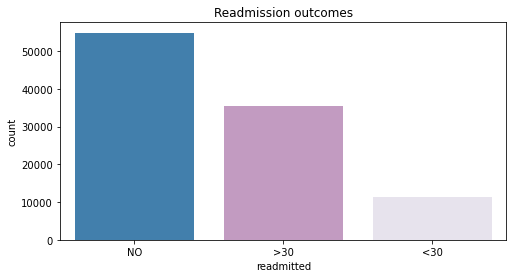

In [5]:
# plot bar chart
plt.figure(figsize=(8,4))
sns.countplot(df['readmitted'], palette=['#3182bd','#c994c7','#e7e1ef'])
plt.title('Readmission outcomes');

In [6]:
print('\n')

We see that **54%** of patients of the dataset were not readmitted, **35%** were readmitted after 30 days, and only **11%** were readmitted before 30 days.

Since classification problems are sensitive to class imbalance, I will combine the before and after 30 days of readmission patients into a single outcome. 

Now, we see a relatively more equal frequency of patients in each outcome. 

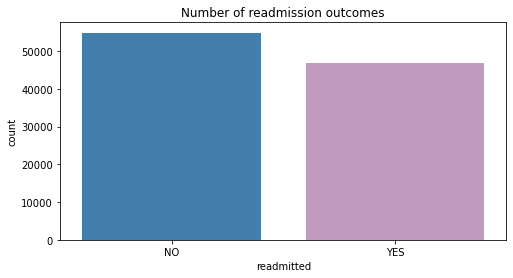

In [7]:
# re-group readmission outcomes
df['readmitted'] = df['readmitted'].map({'>30':'YES', '<30':'YES', 'NO':'NO'})

# plot bar chart
plt.figure(figsize=(8,4))
sns.countplot(df['readmitted'], palette=['#3182bd','#c994c7'])
plt.title('Number of readmission outcomes');

---

<a id='patient_duplicates'></a>
**Patient duplicates**

`patient_nbr` indicates the unique identifier for each patient. We see that there are duplicates in the patient IDs.

It may be that the 'unique' identifier is the same for different patients who attend different hospitals. If so, then the IDs are simply not in synced across different hospitals.

When I look at the duplicated `patient_nbr` IDs, I noticed that data recorded across the other features are different, which either implies the above, or that each patient ID represents a unique ADMISSION across time, regardless of whether or not the patient has had more than one admission within the same hospital.

In any case, I will not be removing these patient ID duplicates.

In [8]:
df['patient_nbr'].nunique()

71518

In [9]:
df[df['patient_nbr'].duplicated()].sort_values(['patient_nbr']).tail(10)

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
95599,363787034,187298114,Caucasian,Male,[80-90),?,1,6,7,4,...,No,Up,No,No,No,No,No,Ch,Yes,YES
97060,383786948,187298114,Caucasian,Male,[80-90),?,1,1,7,2,...,No,Steady,No,No,No,No,No,Ch,Yes,YES
96587,377345516,187298114,Caucasian,Male,[80-90),?,1,1,7,3,...,No,Steady,No,No,No,No,No,Ch,Yes,NO
92475,322610720,187298114,Caucasian,Male,[80-90),?,1,1,7,2,...,No,Steady,No,No,No,No,No,No,Yes,YES
99386,412637672,187920311,Caucasian,Female,[60-70),?,1,22,7,2,...,No,Steady,No,No,No,No,No,Ch,Yes,YES
99239,410904182,188238020,Caucasian,Female,[80-90),?,1,3,7,3,...,No,Down,No,No,No,No,No,Ch,Yes,YES
97639,390910244,188284883,Other,Female,[80-90),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
99544,414418886,188634893,Caucasian,Male,[70-80),?,1,1,7,2,...,No,Steady,No,No,No,No,No,No,Yes,NO
101595,441488168,188970179,Asian,Female,[70-80),?,1,3,7,6,...,No,Steady,No,No,No,No,No,No,Yes,NO
98191,397823084,189257846,Asian,Male,[60-70),?,1,1,7,2,...,No,Steady,No,No,No,No,No,No,Yes,YES


---

<a id='missing_values'></a>
**Missing values**

Missing values of the dataset are represented as `?`. Features with missing values are `race`, `weight`, `payer_code`, `medical_specialty`, `diag_1`, `diag_2`, and `diag_3`.

- `race`: 2% of patients did not disclose their races. I will drop these patients from the dataset.
- `weight`: 97% of weights are not filled. This represents a very large portion of the dataset. I will remove this feature entirely from my dataset.
- `payer_code`: 40% of payer codes were not filled. In this instance, it is difficult to impute missing payer codes, given that there are currently 23 distinct payer codes. I will also remove this feature entirely from my dataset. 
- `medical_specialty`: 49% of medical specialties, which indicate the specialty of the admitting physician, are missing. I will also remove this feature entirely from my dataset.

I also drop the identifiers of patients as they do not provide me with any insight: `encounter_id` and `patient_nbr`.

In [10]:
for i in df.columns:
    try:
        if True in df[i].str.contains('\?').unique().tolist():
            print(i)
    except:
        pass

race
weight
payer_code
medical_specialty
diag_1
diag_2
diag_3


**Encounter and patient unique identifiers**

Drop columns

In [11]:
del df['encounter_id']
del df['patient_nbr']

**Race**

Reclassify missing races as 'other', and drop these rows.

In [12]:
# regroup missing races as 'other'
df['race'].value_counts()

Caucasian          76099
AfricanAmerican    19210
?                   2273
Hispanic            2037
Other               1506
Asian                641
Name: race, dtype: int64

In [13]:
df['race'] = df['race'].str.replace('?', 'Other')
df['race'].value_counts()

Caucasian          76099
AfricanAmerican    19210
Other               3779
Hispanic            2037
Asian                641
Name: race, dtype: int64

In [14]:
df = df[~df['race'].str.contains('Other')]

**Weight**

Remove column from dataset.

In [15]:
del df['weight']

**Payer code**

Remove column from dataset.

In [16]:
del df['payer_code']

**Medical specialty**

Remove column from dataset.

In [17]:
del df['medical_specialty']

---

<a id='recode_values'></a>
**Re-code values and collapsing features**

Now, I re-group values of features where necessary, whether based on similar characteristics or similar trends with regards to readmission outcome. This is to reduce the multidimensionality of the dataset. 

However, since I do not have a strong knowledge in the medical domain, I try to employ as much common sense as available to me in cases where patterns of differentiation may be observed. 

In [18]:
print('\n')

**1) Gender**

The plots show a similar pattern of readmission outcome between female and male patients - there are more patients who were not readmitted across both genders. However, we see that a higher proportion of female patients were readmitted, as compared to male patients. 

In [19]:
df['gender'].value_counts()

Female    52827
Male      45160
Name: gender, dtype: int64

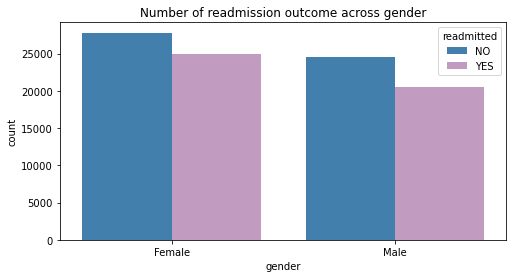

In [20]:
# plot bivariate clustered bar chart
plt.figure(figsize=(8,4))
sns.countplot(df['gender'], hue=df['readmitted'], palette=['#3182bd','#c994c7'])
plt.title('Number of readmission outcome across gender');

**2) Age**

The ages of patients were recorded in categorical ranges in intervals of 10: 0-10, 10-20, 20-30 etc.

All age groups seem to share a similar pattern of readmission outcome, with a higher number of no readmissions than readmissions. We see however, that the proportion of readmissions is higher among older groups (we see a narrower gap in the height of bars between blue and purple  above 70 years of age, as compared to ages between 40 and 70).

In addition, I will convert this feature from a categorical to numeric, by taking the mid-point of each age group. 

In [21]:
# convert age ranges that were recorded as [10-20) to 10-20
df['age'] = df['age'].str.replace('[', '')
df['age'] = df['age'].str.replace(')', '')

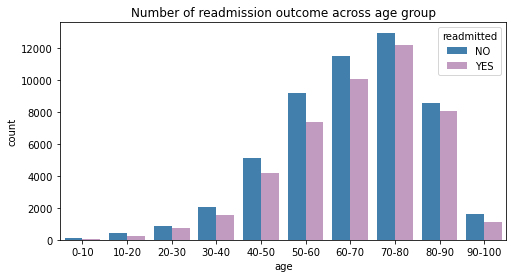

In [22]:
# plot
plt.figure(figsize=(8,4))
sns.countplot(df['age'], hue=df['readmitted'], palette=['#3182bd','#c994c7'])
plt.title('Number of readmission outcome across age group');

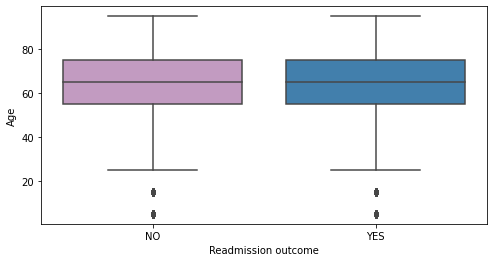

In [23]:
# re-group ages
df['age'] = df['age'].map({'0-10':'5',
                           '10-20':'15',
                           '20-30':'25',
                           '30-40':'35',
                           '40-50':'45',
                           '50-60':'55',
                           '60-70':'65',
                           '70-80':'75',
                           '80-90':'85',
                           '90-100':'95'})

# convert to numeric feature
df['age'] = df['age'].astype(int)

# plot box plots
plt.figure(figsize=(8,4))
sns.boxplot(x=df['readmitted'], y=df['age'],
            palette=['#c994c7','#3182bd'])
plt.ylabel('Age')
plt.xlabel('Readmission outcome');

**3) Admission type**

There are 9 distinct admission types that are represented in unique integers. Admission types are: `emergency`, `urgent`, `elective`, `newborn`, `trauma`. There are also undisclosed admission types that are recorded as `other`. 

Since they are recorded in integers, I will map them to their admission types in string format so that I can look at them better. The integers and their corresponding admission types can be found [here](https://archive.ics.uci.edu/ml/machine-learning-databases/00296/).

In [24]:
admission_type_dict = {1:'emergency',
                       2:'urgent',
                       3:'elective',
                       4:'newborn',
                       5:'other',
                       6:'other',
                       7:'trauma',
                       8:'other'}

df['admission_type_id'] = df['admission_type_id'].map(admission_type_dict)
df['admission_type_id'].value_counts()

emergency    52216
elective     18233
urgent       17407
other        10101
trauma          20
newborn         10
Name: admission_type_id, dtype: int64

In the plot below, we see that all trauma patients of the dataset did not get readmitted. Seems like the largest proportion of patients who were readmitted come from admission types `other` and `emergency`. On the other hand, `newborn` and `elective` had the lowest proportion of readmissions.

In [25]:
# create a table of proportions for each admission type and each readmitted type
output1 = pd.crosstab(df['admission_type_id'], df['readmitted']).apply(lambda x: round((x/x.sum())*100, 1), axis=1)
output1

readmitted,NO,YES
admission_type_id,,
elective,58.9,41.1
emergency,52.4,47.6
newborn,70.0,30.0
other,50.3,49.7
trauma,100.0,0.0
urgent,52.8,47.2


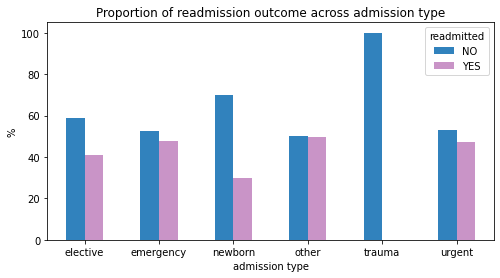

In [26]:
# plot
output1.plot.bar(figsize=(8,4), color=['#3182bd','#c994c7'])
plt.title('Proportion of readmission outcome across admission type')
plt.xlabel('admission type')
plt.xticks(rotation=360)
plt.ylabel('%');

I will remove patients with undisclosed admission types, and re-group all non-emergency admission types into one group called `non-emergency`.

In the plot below, we see that among patients who were admitted due to emergency reasons, a higher proportion were readmitted, as compared to those who came in due to non-emergency reasons.

In [27]:
# remove 'other'
df = df.query('admission_type_id != "other"')

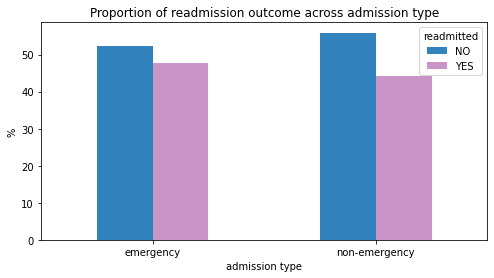

In [28]:
# re-group to emergency and non-emergency only
df['admission_type_id'] = df['admission_type_id'].map({'elective':'non-emergency',
                                                       'emergency':'emergency',
                                                       'newborn':'non-emergency',
                                                       'trauma':'non-emergency',
                                                       'urgent':'non-emergency'})

# create a table of proportions for each admission type and each readmitted type
output1_1 = pd.crosstab(df['admission_type_id'], df['readmitted']).apply(lambda x: round((x/x.sum())*100, 1), axis=1)
output1_1

# plot bar chart
output1_1.plot.bar(figsize=(8,4), color=['#3182bd','#c994c7'])
plt.title('Proportion of readmission outcome across admission type')
plt.xlabel('admission type')
plt.xticks(rotation=360)
plt.ylabel('%');

**4) Discharge disposition**

There are 29 distinct discharge reasons. For example, a patient may be discharged home or discharged to another medical institution, which takes various forms such as short term hospital, inpatient care institution, Medicare approved swing bed, and many more. I will group all discharge destinations that are not to a patient's home (even if it is a home with home health services) as being discharged to a medical institution.

Another thing to note is that some discharge reasons were recorded as `expired`. These are patients that had passed away during their admission, which I remove from the dataset. I also remove patients with undisclosed discharge dispositions.

**Remove patients that had passed away during their hospital stay**

In [29]:
# import csv file containing the maps
data_map = pd.read_csv('./data/id_mapping.csv')

In [30]:
# Create mapping dictionary
discharge_disposition_df = data_map[11:41]
discharge_disposition_df.columns = 'discharge_disposition_id', 'description'
discharge_disposition_df['description'] = discharge_disposition_df['description'].str.lower()
discharge_disposition_df.set_index(['discharge_disposition_id'], inplace=True)
discharge_disposition_df.fillna('none', inplace=True)
discharge_disposition_df.index = discharge_disposition_df.index.astype(int)
discharge_disposition_dict = discharge_disposition_df.to_dict()['description']
# discharge_disposition_dict

In [31]:
# map dispositions to integers
df['discharge_disposition_id'] = df['discharge_disposition_id'].map(discharge_disposition_dict)

In [32]:
# count number of patients who had passed away and patients discharged to
# hospice
print(f"a total of {df['discharge_disposition_id'].str.contains('expire').sum():,.0f}\
 patients had passed away, while a total of {df['discharge_disposition_id'].str.contains('hospice /').sum()}\
 patients were headed to a hospice")

a total of 1,443 patients had passed away, while a total of 660 patients were headed to a hospice


In [33]:
# confirm that 'expired' patients were not readmitted at all
df[df['discharge_disposition_id'].str.contains('expire')]['readmitted'].unique()

array(['NO'], dtype=object)

In [34]:
# will not remove hospice patients
df[df['discharge_disposition_id'].str.contains('hospice')]['readmitted'].value_counts()

NO     589
YES     80
Name: readmitted, dtype: int64

In [35]:
# remove patients who had passed away from the dataset
df = df[~df['discharge_disposition_id'].str.contains('expire')]
df.shape

(86443, 45)

**Re-group discharge dispositions to either `home`, `medical institution`, `left AMA`, `hospice`, or `other` where `other` contain missing discharge dispositions.**

In [36]:
# define function for classification based on whether 'expire' is in the discharge disposition
def classify_discharge_disposition(df):
    if 'left ama' in df:
        return 'left ama'
    if 'none' in df:
        return 'other'
    if 'not mapped' in df:
        return 'other'
    if 'unknown' in df:
        return 'other'
    elif 'hospice' in df:
        return 'hospice'
    else:
        return df # differentiate the home and medical institution ones later

In [37]:
# define second function to differentiate home and medical institution discharge
def classify_discharge_disposition2(df):
    if 'home' in df:
        return 'home'
    elif 'left ama' in df:
        return 'left ama'
    elif 'other' in df:
        return 'other'
    else:
        return 'medical institution'

In [38]:
# apply 1st and 2nd map functions
df['discharge_disposition_id'] = df['discharge_disposition_id'].map(classify_discharge_disposition)
df['discharge_disposition_id'] = df['discharge_disposition_id'].map(classify_discharge_disposition2)
df['discharge_disposition_id'].value_counts()

home                   64002
medical institution    13628
other                   8276
left ama                 537
Name: discharge_disposition_id, dtype: int64

The plot below shows that the largest proportion of patients who were readmitted are those who left against medical advice, while the smallest proportion are those who were discharged home.

In [39]:
# remove 'others'
df = df.query('discharge_disposition_id != "other"')

In [40]:
# create a table of proportions for each discharge reason and each readmitted type
output2 = pd.crosstab(df['discharge_disposition_id'], df['readmitted']).apply(lambda x: round((x/x.sum())*100, 1), axis=1)
output2

readmitted,NO,YES
discharge_disposition_id,,
home,53.2,46.8
left ama,48.8,51.2
medical institution,52.3,47.7


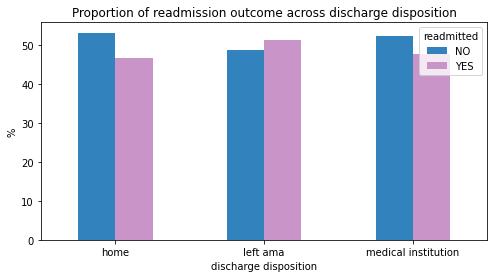

In [41]:
# plot bar chart
output2.plot.bar(figsize=(8,4), color=['#3182bd','#c994c7'])
plt.title('Proportion of readmission outcome across discharge disposition')
plt.xlabel('discharge disposition')
plt.xticks(rotation=360)
plt.ylabel('%');

**5) Admission source**

There are 21 distinct admission sources describing the source of which patients were referred for the initial admission, such as physical referral, clinic referral, emergency referral, and others. 

Looks like most patients were admitted from the emergency room, followed by physician referrals. Other sources include transfer from another healthcare facility, from another critical access hospital, from an ambulatory surgery centre, and others.

I will drop this feature from my dataset, seeing as I am unsure of how the various referral sources differ or overlap in service with each other. Furthermore, I'd imagine that these admission sources are also reflective of the admission types (emergency, elective, newborn etc), which we have in the dataset. 

In [42]:
# map admission source from their integers
admission_source_df = data_map[43:]
admission_source_df.columns = ['admission_source_id', 'description']
admission_source_df.fillna('not available', inplace=True)
admission_source_df.set_index(['admission_source_id'], inplace=True)
admission_source_df.index = admission_source_df.index.astype(int)
admission_source_df['description'] = admission_source_df['description'].str.lower()
admission_source_dict = admission_source_df.to_dict()
admission_source_dict = admission_source_dict['description']

df['admission_source_id'] = df['admission_source_id'].map(admission_source_dict)
df['admission_source_id'].value_counts()

emergency room                                               47987
physician referral                                           23568
transfer from a hospital                                      2226
transfer from another health care facility                    1799
not available                                                  841
clinic referral                                                802
transfer from a skilled nursing facility (snf)                 665
not mapped                                                     156
hmo referral                                                    89
transfer from hospital inpt/same fac reslt in a sep claim       11
court/law enforcement                                            9
transfer from critial access hospital                            7
normal delivery                                                  2
extramural birth                                                 2
transfer from ambulatory surgery center                       

In [43]:
# drop feature
del df['admission_source_id']

In [173]:
print('\n')

**6) Duration of hospital stay in days**

Unlike the categorical features that I was describing before, this feature is numerical, indicating the number of days a patient was admitted in the hospital. The shortest hospital stay is 1 day while the longest is 14 days. 

Our dataset shows that a majority of patients were admitted for less than 6 days, with a  decreasing number as days increase to 14 days (reflecting a rightly-skewed histogram).

For my decision tree, I will not be log-transforming this feature into a normally distributed plot, since this feature is not the target variable. 

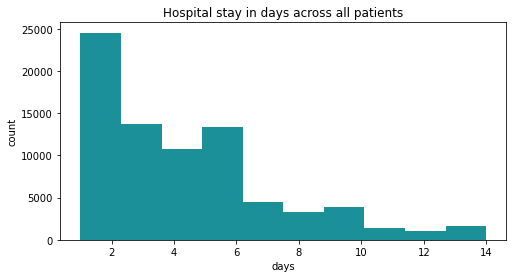

In [44]:
# plot histogram to show spread of hospital stay 
plt.figure(figsize=(8,4))
plt.hist(df['time_in_hospital'], color='#1c9099')
plt.title('Hospital stay in days across all patients')
plt.xlabel('days')
plt.ylabel('count');

Let us look at the relationship between readmission outcome and the amount of time spent during admission.

From the boxplots below, we see that patients who did not get readmitted had a lower *median* number of admission days (**3 days**), as compared to patients who did get readmitted (**4 days**). Nevertheless, we see a significant overlap in the number of admission days for both readmission outcomes.

The *average* number of days for patients who were readmitted is also *slightly* higher than those who were not (**4.5 days** vs **4.2 days**).

In [45]:
# calculate average hospital stay by readmitted outcome
df.groupby('readmitted')['time_in_hospital'].mean()

readmitted
NO     4.193671
YES    4.496938
Name: time_in_hospital, dtype: float64

In [46]:
# calculate median hospital stay by readmitted outcome
df.groupby('readmitted')['time_in_hospital'].median()

readmitted
NO     3
YES    4
Name: time_in_hospital, dtype: int64

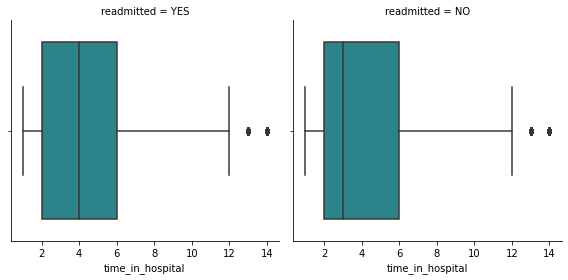

In [47]:
# plot facet grid of box plots
g = sns.FacetGrid(df, col='readmitted', size=4)
g.map(sns.boxplot, 'time_in_hospital', color='#1c9099');

We see that a larger proportion of patients who were not readmitted had a shorter admission time, as compared to patients who were readmitted.

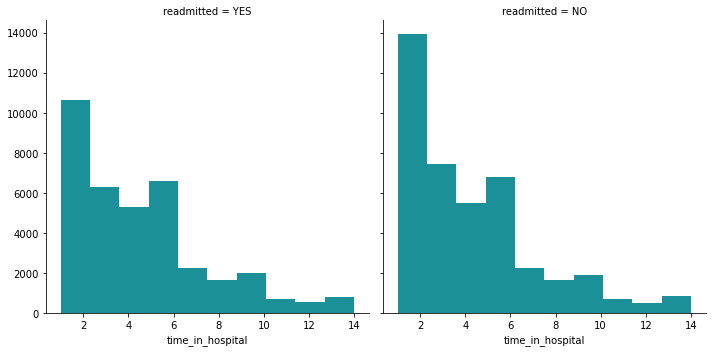

In [48]:
# plot facet grid of histograms
g = sns.FacetGrid(df, col='readmitted', size=5)
g.map(plt.hist, 'time_in_hospital', bins=10, color='#1c9099');

**7) Number of lab tests performed**

The lowest number of lab tests performed on patients of the dataset is 1, while the highest is 132 tests. 

The histograms below show a similar distribution of number of lab procedures performed across both readmission groups. Nevertheless, the average number of lab tests given to patients who were admitted is slightly higher (44 tests) than for patients who were not readmitted (42 tests). 

The boxplots show overlapping number of lab procedures across both readmission groups.

In [49]:
# separate dfs to plot overlapping histograms later
lab_readmitted_yes = df.query('readmitted == "YES"')
lab_readmitted_no = df.query('readmitted == "NO"')

# calculate mean values to be plot later
mean_lab_readmitted_yes = lab_readmitted_yes['num_lab_procedures'].mean()
mean_lab_readmitted_no = lab_readmitted_no['num_lab_procedures'].mean()

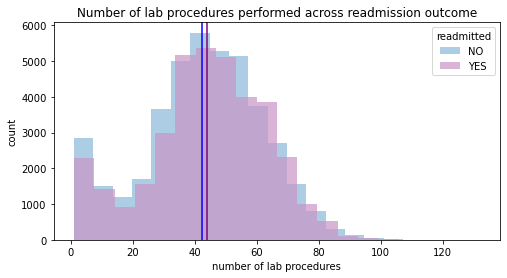

In [50]:
# plot histogram
plt.figure(figsize=(8,4))
plt.hist(lab_readmitted_no['num_lab_procedures'], 
         color='#3182bd', alpha=0.4, bins=20, label='NO')
plt.axvline(mean_lab_readmitted_no, color='blue')
plt.hist(lab_readmitted_yes['num_lab_procedures'], 
         color='#c994c7', alpha=0.7, bins=20, label='YES')
plt.axvline(mean_lab_readmitted_yes, color='purple')
plt.legend(title='readmitted')
plt.title('Number of lab procedures performed across readmission outcome')
plt.ylabel('count')
plt.xlabel('number of lab procedures');

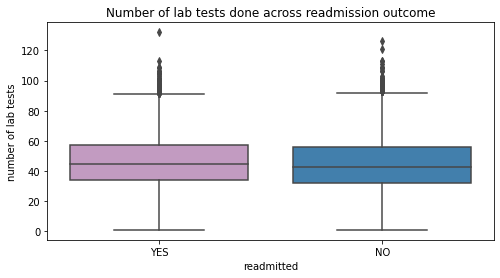

In [51]:
# plot box plots
plt.figure(figsize=(8,4))
sns.boxplot(x=df['readmitted'], y=df['num_lab_procedures'],
            palette=['#c994c7','#3182bd'])
plt.title('Number of lab tests done across readmission outcome')
plt.ylabel('number of lab tests')
plt.xlabel('readmitted');

**8) Number of non-lab procedures performed**

The lowest number of non-laboratory tests performed on patients of the dataset is 0, while the highest is 6.

The pattern of non-lab tests performed across readmission outcomes is similar to the number of lab tests performed. So, I combine both these features into a single feature called `num_tests`.

In [52]:
# separate dfs to plot overlapping histograms later
nonlab_readmitted_yes = df.query('readmitted == "YES"')
nonlab_readmitted_no = df.query('readmitted == "NO"')

# calculate mean values to be plot later
mean_nonlab_readmitted_yes = nonlab_readmitted_yes['num_procedures'].mean()
mean_nonlab_readmitted_no = nonlab_readmitted_no['num_procedures'].mean()

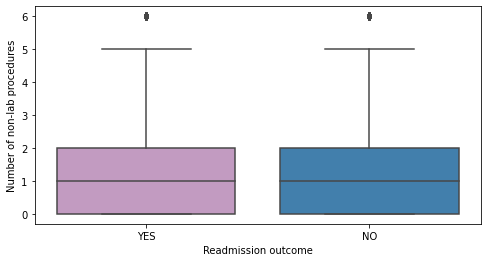

In [53]:
# plot box plots
plt.figure(figsize=(8,4))
sns.boxplot(x=df['readmitted'], y=df['num_procedures'],
            palette=['#c994c7','#3182bd'])
plt.ylabel('Number of non-lab procedures')
plt.xlabel('Readmission outcome');

I combine the number of lab and non-lab procedures into a single feature: `num_tests`

In [54]:
df['num_tests'] = df['num_lab_procedures'] + df['num_procedures']

# remove 'num_lab_procedures' and 'num_procedures'
del df['num_lab_procedures']
del df['num_procedures']

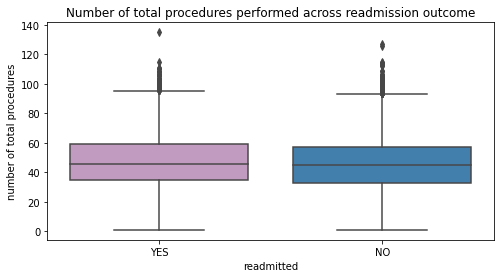

In [55]:
# plot box plots
plt.figure(figsize=(8,4))
sns.boxplot(x=df['readmitted'], y=df['num_tests'],
            palette=['#c994c7','#3182bd'])
plt.title('Number of total procedures performed across readmission outcome')
plt.ylabel('number of total procedures')
plt.xlabel('readmitted');

**9) Number of medications**

The lowest number of medications given to patients of the dataset is 1, while the highest is 81.

The average number of medications given among patients who were readmitted is higher (16.3) than for patients who were not readmitted (15.4).

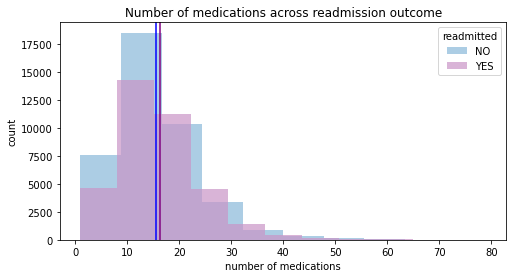

In [56]:
# separate dfs to plot overlapping histograms later
nonlab_readmitted_yes = df.query('readmitted == "YES"')
nonlab_readmitted_no = df.query('readmitted == "NO"')

# calculate mean values to be plot later
mean_med_readmitted_yes = nonlab_readmitted_yes['num_medications'].mean()
mean_med_readmitted_no = nonlab_readmitted_no['num_medications'].mean()

# plot histogram
plt.figure(figsize=(8,4))
plt.hist(nonlab_readmitted_no['num_medications'], 
         color='#3182bd', alpha=0.4, label='NO')
plt.axvline(mean_med_readmitted_no, color='blue')
plt.hist(nonlab_readmitted_yes['num_medications'], 
         color='#c994c7', alpha=0.7, label='YES')
plt.axvline(mean_med_readmitted_yes, color='purple')
plt.legend(title='readmitted')
plt.title('Number of medications across readmission outcome')
plt.ylabel('count')
plt.xlabel('number of medications');

**10) Number of outpatient visits in the preceding year**

The lowest number of outpatient visits is 0 and the highest is 42.

A great majority of patients from both readmission outcomes had 0 outpatient visits. However, there is a higher number of larger outliers among patients who were readmitted.

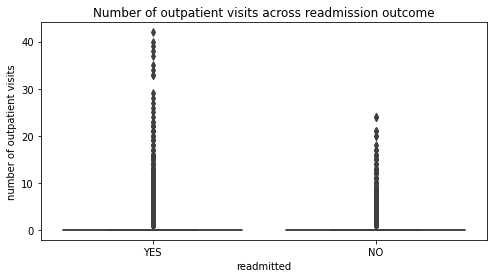

In [57]:
# plot boxplots
plt.figure(figsize=(8,4))
sns.boxplot(df['readmitted'], df['number_outpatient'])
plt.title('Number of outpatient visits across readmission outcome')
plt.xlabel('readmitted')
plt.ylabel('number of outpatient visits');

**11) Number of emergency visits in the preceding year**

Similar to the number of outpatient visits, a vast majority of patients (**88%**) had 0 emergency visits in the year before their admission, followed by **7.5%** who only had 1 emergency visit. Also, there is a higher number of larger outliers in the number of emergency visits among patients who were readmitted vs patients who were not.

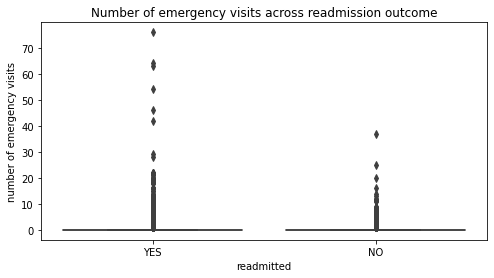

In [58]:
# plot boxplots 
plt.figure(figsize=(8,4))
sns.boxplot(df['readmitted'], df['number_emergency'])
plt.title('Number of emergency visits across readmission outcome')
plt.xlabel('readmitted')
plt.ylabel('number of emergency visits');

**12) Number of inpatient visits in the preceding year**

A larger proportion of patients who were readmitted had at least 1 inpatient visit, as compared to a majority of patients who were not readmitted, who majorly had 0 inpatient visits. 

This is in contrast to the number of *outpatient* and *emergency* visits, where 0 outpatient and 0 emergency visits seem to be the norm amongst patients. 

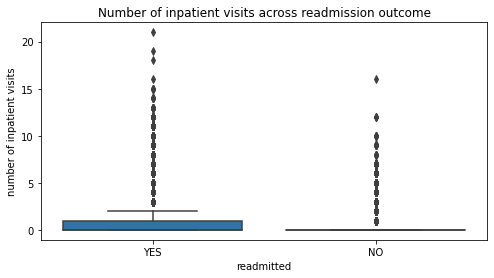

In [59]:
# plot
plt.figure(figsize=(8,4))
sns.boxplot(df['readmitted'], df['number_inpatient'])
plt.title('Number of inpatient visits across readmission outcome')
plt.xlabel('readmitted')
plt.ylabel('number of inpatient visits');

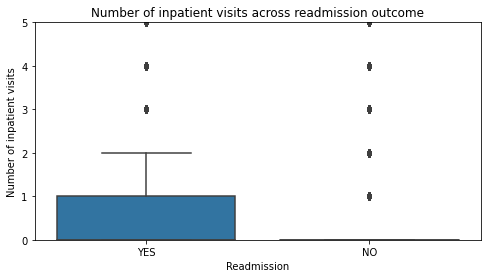

In [60]:
# plot
plt.figure(figsize=(8,4))
sns.boxplot(df['readmitted'], df['number_inpatient'])
plt.title('Number of inpatient visits across readmission outcome')
plt.xlabel('Readmission')
plt.ylim(0,5)
plt.ylabel('Number of inpatient visits');

I combine the number of inpatient, outpatient, and emergency visits into a single feature: `num_services_utilized`.

In [61]:
df['num_services_utilized'] = df['number_inpatient'] + df['number_outpatient'] + df['number_emergency']

del df['number_inpatient']
del df['number_outpatient']
del df['number_emergency']

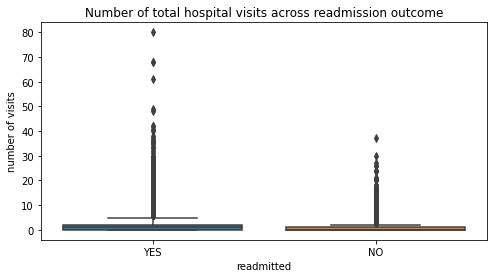

In [62]:
# plot
plt.figure(figsize=(8,4))
sns.boxplot(df['readmitted'], df['num_services_utilized'])
plt.title('Number of total hospital visits across readmission outcome')
plt.xlabel('readmitted')
plt.ylabel('number of visits');

**13) ICD-9 diagnoses**

The dataset has 848 distinct diagnoses that are recorded across patients as their primary diagnosis, along with 923 distinct secondary diagnoses, and 954 distinct additional secondary diagnosis.

I will not be looking at the secondary and additional secondary diagnoses, only the primary ones.

The [ICD-9-CM Chapters List](https://icd.codes/icd9cm) provides a list of 3-digit codes corresponding to each ICD-9 diagnosis. I will map these diagnoses to my feature. Each diagnosis is not a specific health condition, but rather an 'umbrella' group of health conditions. For example, 3-digit codes ranging between 290 and 310 are mental health related disorders.

Since the values in `diag_1` are in string format due to some 3 digit codes that start with V and E, I will replace V with 10, and E with 20. This converts the V and E starting 3 digit codes into one thousands and two thousands, which makes it much simpler for the mapping.

In [63]:
# convert V and E to 10 and 20 respectively
df['diag_1'] = df['diag_1'].str.replace('V', '10')
df['diag_1'] = df['diag_1'].str.replace('E', '20')

I also found 16 missing diagnosis codes. I will remove these patients from my dataset.

I am now left with 81,329 rows.

In [64]:
# missing values?
df['diag_1'].str.contains('\?').sum()

15

In [65]:
len(df)

78167

In [66]:
# remove missing values
df = df[~df['diag_1'].str.contains('\?')]
len(df)

78152

In [67]:
# convert string to integer
df['diag_1'] = df['diag_1'].astype(float)

In [68]:
# define classification function
def classify_diagnosis_codes(df):
    if 1 <= df <= 139:
        return 'infectious and parasitic diseases'
    elif 140 <= df <= 239:
        return 'neoplasms'
    elif 240 <= df <= 279:
        return 'endocrine, nutritional, metabolic diseases, immunity disorders'
    elif 280 <= df <= 289:
        return 'diseases of the blood'
    elif 290 <= df <= 319:
        return 'mental disorders'
    elif 320 <= df <= 389:
        return 'diseases of the nervous system'
    elif 390 <= df <= 459:
        return 'diseases of the circulatory system'
    elif 460 <= df <= 519:
        return 'diseases of the respiratory system'
    elif 520 <= df <= 579:
        return 'diseases of the digestive system'
    elif 580 <= df <= 629:
        return 'diseases of the genitourinary system'
    elif 630 <= df <= 679:
        return 'complications of pregnancy, childbirth'
    elif 680 <= df <= 709:
        return 'diseases of the skin'
    elif 710 <= df <= 739:
        return 'diseases of the musculoskeletal system'
    elif 740 <= df <= 759:
        return 'congenital anomalies'
    elif 760 <= df <= 779:
        return 'originating in the perinatal period'
    elif 780 <= df <= 799:
        return 'symptoms, signs, and ill-defined conditions'
    elif 800 <= df <= 999:
        return 'injury and poisoning'
    elif 1000 <= df < 2000:
        return 'factors affecting health status'
    elif df >= 2000:
        return 'external causes of injury'
    else:
        return df

The top three conditions that were the primary diagnoses of patients are (1) diseases of the circulatory system; (2) endocrine, nutritional, metabolic diseases, and immunity disorders; and (3) diseases of the respiratory system.

I will re-group all diseases related to infants and pregnancies to a single group `maternal and child`.

In [69]:
# apply function
df['diag_1'] = df['diag_1'].apply(classify_diagnosis_codes)
df['diag_1'].value_counts()

diseases of the circulatory system                                22762
endocrine, nutritional, metabolic diseases, immunity disorders     9075
diseases of the respiratory system                                 8147
diseases of the digestive system                                   7353
symptoms, signs, and ill-defined conditions                        6016
injury and poisoning                                               5063
diseases of the genitourinary system                               4119
diseases of the musculoskeletal system                             3457
neoplasms                                                          2648
infectious and parasitic diseases                                  2137
diseases of the skin                                               2062
mental disorders                                                   1672
factors affecting health status                                    1141
diseases of the nervous system                                  

In [70]:
# re-group
df['diag_1'] = df['diag_1'].str.replace('complications of pregnancy, childbirth', 'maternal and child')
df['diag_1'] = df['diag_1'].str.replace('congenital anomalies', 'maternal and child')

df['diag_1'] = df['diag_1'].str.replace('external causes of injury', 'injury and poisoning')

In [71]:
# re-count
df['diag_1'].value_counts()

diseases of the circulatory system                                22762
endocrine, nutritional, metabolic diseases, immunity disorders     9075
diseases of the respiratory system                                 8147
diseases of the digestive system                                   7353
symptoms, signs, and ill-defined conditions                        6016
injury and poisoning                                               5064
diseases of the genitourinary system                               4119
diseases of the musculoskeletal system                             3457
neoplasms                                                          2648
infectious and parasitic diseases                                  2137
diseases of the skin                                               2062
mental disorders                                                   1672
factors affecting health status                                    1141
diseases of the nervous system                                  

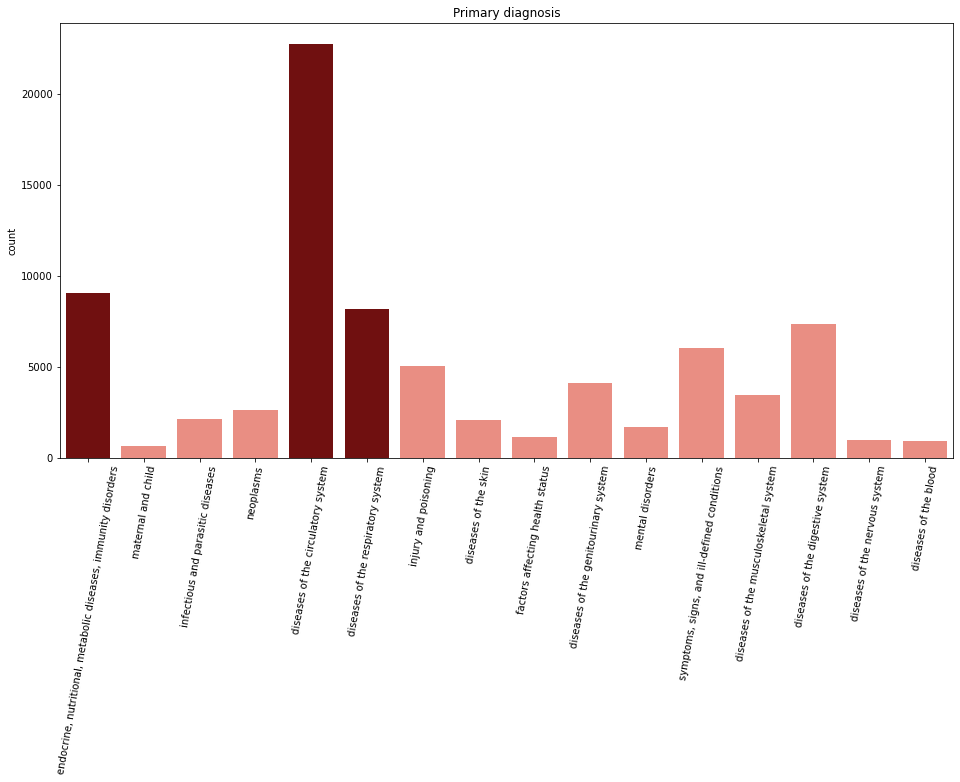

In [72]:
# plot bar chart
palette1 = ['maroon','salmon','salmon','salmon','maroon','maroon',
            'salmon','salmon','salmon','salmon','salmon','salmon',
            'salmon','salmon','salmon','salmon']

plt.figure(figsize=(16,8))
sns.countplot(df['diag_1'], palette=palette1)
plt.title('Primary diagnosis')
plt.xlabel('')
plt.xticks(rotation=80);

When we look at the proportion of readmission outcome across all primary diagnoses, we see in particular that a larger proportion of diabetic patients with (1) diseases of the blood; (2) diseases of the respiratory system; and (3) diseases of the endocrine, nutritional, metabolic and immunity system, were readmitted than not. 

In [73]:
# create a table of proportions for each primary diagnosis and each readmitted type
output3 = pd.crosstab(df['diag_1'], df['readmitted']).apply(lambda x: round((x/x.sum())*100, 1), axis=1)

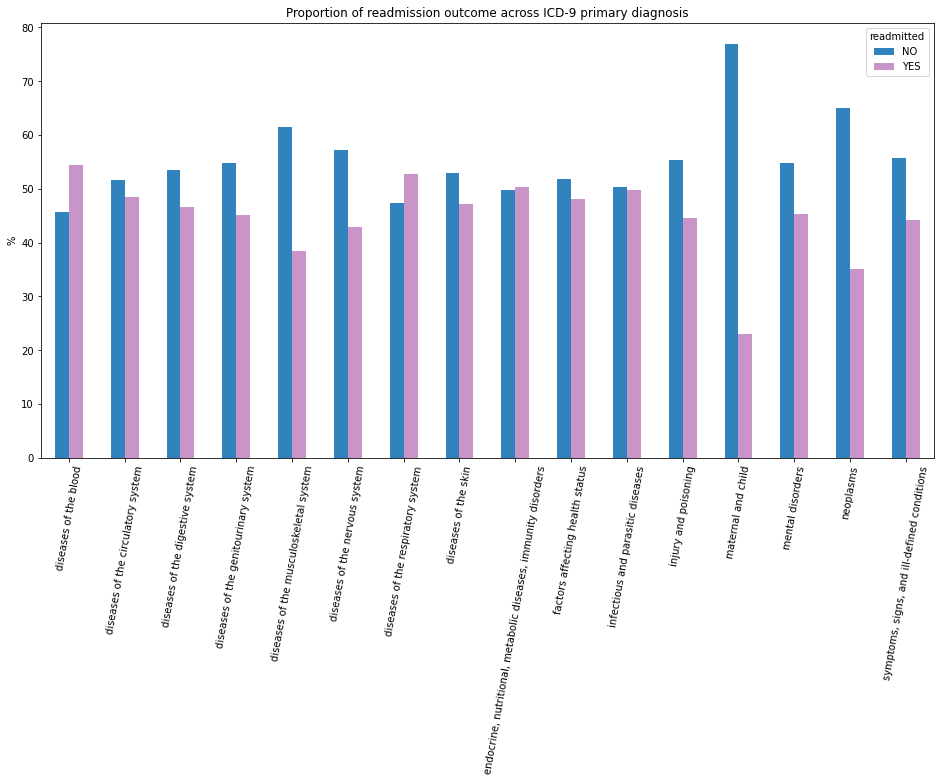

In [74]:
# plot bar chart
output3.plot.bar(figsize=(16,8), color=['#3182bd','#c994c7'])
plt.title('Proportion of readmission outcome across ICD-9 primary diagnosis')
plt.xticks(rotation=80)
plt.xlabel('')
plt.ylabel('%');

In [75]:
# delete 'diag_2' and 'diag_3'
df.drop(['diag_2', 'diag_3'], axis=1, inplace=True)

**14) Number of diagnoses**

The number of diagnoses that was entered into the system. 16 is the highest number of diagnoses while 1 is the least. Most patients had 9 conditions diagnosed, at **48%**.

The median number of diagnoses is higher among patients who were readmitted as compared to those who were not. Nevertheless, there are still major overlaps between the box plots.

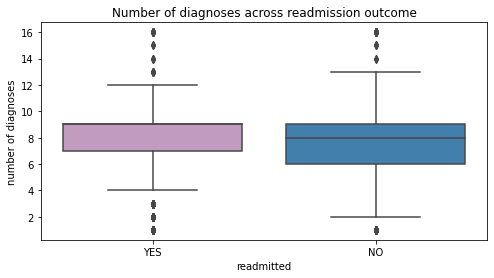

In [76]:
# plot boxplots
plt.figure(figsize=(8,4))
sns.boxplot(df['readmitted'], df['number_diagnoses'],
            palette=['#c994c7','#3182bd'])
plt.title('Number of diagnoses across readmission outcome')
plt.xlabel('readmitted')
plt.ylabel('number of diagnoses');

**15) Glucose serum test results**

The glucose serum test is a blood glucose test that screens for diabetes by measuring the level of sugar in a person's blood.

The dataset records the blood sugar measurements in categories (`>200`, `>300`, `normal`), or if the test was not taken (`none`). **94%** of patients did not have their glucose serum tests taken.

The bar charts show us that among patients who had taken the test, those who recorded >300 had a higher proportion of being readmitted, as compared to patients in the other glucose groups.

In [77]:
df['max_glu_serum'].value_counts()

None    77157
Norm      482
>300      346
>200      167
Name: max_glu_serum, dtype: int64

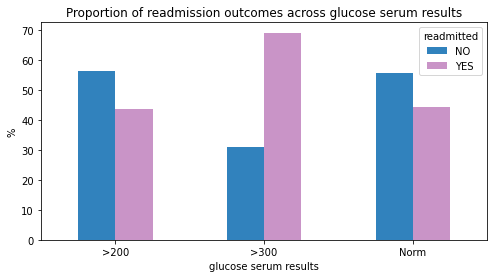

In [78]:
# plot clustered bar charts without None 'max_glu_serum'
df1 = df.query('max_glu_serum != "None"')

# create a table of proportions 
output4 = pd.crosstab(df1['max_glu_serum'], df1['readmitted']).apply(lambda x: round((x/x.sum())*100, 1), axis=1)

output4.plot.bar(figsize=(8,4), color=['#3182bd','#c994c7'])
plt.title('Proportion of readmission outcomes across glucose serum results')
plt.xticks(rotation=360)
plt.xlabel('glucose serum results')
plt.ylabel('%');

**16) A1c test results**

The A1c test is a blood test that measures a person's average blood sugar levels over the past 3 months.

The dataset records the test results in categories of `>8` if the result is greater than 8%, `>7` if the result is greater than 7% but less than  8%, `normal` if the result is less than 7%, and `none` if the test was not taken by the patient. **83%** of patients did not have their A1c test taken.

As compared to the glucose serum test results, A1c test results do not seem to have an obvious pattern with readmission outcome.

In [79]:
df['A1Cresult'].value_counts()

None    64931
>8       6206
Norm     4081
>7       2934
Name: A1Cresult, dtype: int64

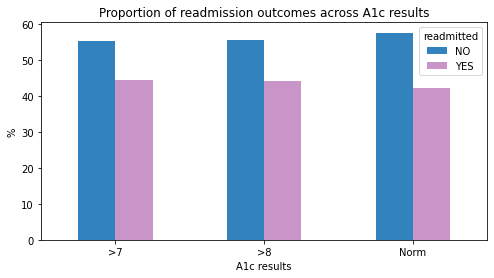

In [80]:
# plot clustered bar charts without None 'max_glu_serum'
df2 = df.query('A1Cresult != "None"')

# create a table of proportions 
output5 = pd.crosstab(df2['A1Cresult'], df2['readmitted']).apply(lambda x: round((x/x.sum())*100, 1), axis=1)

output5.plot.bar(figsize=(8,4), color=['#3182bd','#c994c7'])
plt.title('Proportion of readmission outcomes across A1c results')
plt.xticks(rotation=360)
plt.xlabel('A1c results')
plt.ylabel('%');

**17) Changes in medication dosage - per medicine**

The dataset includes 24 different medications that were either taken by patients in an increasing dosage, decreasing dosage, a steady dosage, or it was not taken at all. The medications include metformin, repaglinide, nateglinide, chlorpropamide, and many others.

Since all patients did not take examide and citoglipton (as indicated in all the values recorded under these 2 features as `no`), I will remove these 2 features from my dataset.

In [81]:
df.drop(['examide', 'citoglipton'], axis=1, inplace=True)

In [145]:
print('\n')

**18) Change of medications**

This feature indicates if there had been a change in **diabetic medication**, either in terms of dosage, or the medication itself. 

Looks like a larger proportion of patients whose medications were changed got readmitted as compared to those whose medications were not changed.

In [82]:
df['change'].value_counts()

No    41474
Ch    36678
Name: change, dtype: int64

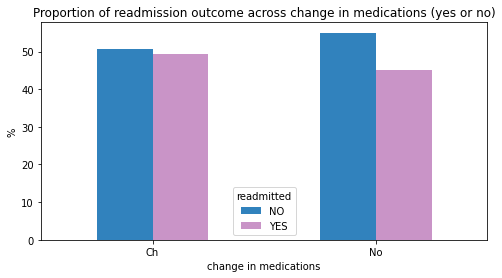

In [83]:
# create a table of proportions 
output6 = pd.crosstab(df['change'], df['readmitted']).apply(lambda x: round((x/x.sum())*100, 1), axis=1)

output6.plot.bar(figsize=(8,4), color=['#3182bd','#c994c7'])
plt.title('Proportion of readmission outcome across change in medications (yes or no)')
plt.xticks(rotation=360)
plt.xlabel('change in medications')
plt.ylabel('%');

**19) Diabetes medications**

Describes whether or not any diabetic medications were prescribed: `yes` or `no`.

The table below shows us the stats.

In [84]:
df.groupby('diabetesMed')['change'].value_counts().to_frame()

change
diabetesMed change        
No          No       17396
Yes         Ch       36678
            No       24078

---

<a id='remove_outliers'></a>
## Removing outliers from numeric features

I define the outlier threshold as lower than and higher than a z-score of -3 and +3 respectively.

In [85]:
# get all numeric features with outliers
to_remove_outliers = []

for i in df.columns:
    if (df[i].dtype == 'int64') or (df[i].dtype == 'float64'):
        to_remove_outliers.append(i)
    
print(f"These features have outliers: {', '.join(to_remove_outliers)}")

These features have outliers: age, time_in_hospital, num_medications, number_diagnoses, num_tests, num_services_utilized


In [86]:
from scipy import stats

# identify outliers and remove them from features
for i in to_remove_outliers:
    df['z_score'] = stats.zscore(df[i])
    df = df.loc[(df['z_score'] >= -3) & (df['z_score'] <= 3)]

---

<a id='label_encode'></a>
## Label encode categorical features

Now that I have explored my features/ predictor variables, dealt with missing data, re-grouped values, and removed outliers, I will be converting my categorical values into numeric values before feeding the decision tree model with the dataset. This is because Python Scikit Learn's decision tree algorithms work best with numeric inputs.

At this point...I am in a bit of a dilemma, because since my categorical features are nominal (aka they do not have a natural ordering to the categories), it is conventional to apply one-hot encoding to them. However, my dataset contains categorical features with high number of categories (high [cardinality](https://www.quora.com/Do-we-need-to-convert-categorical-data-to-numerical-data-before-applying-to-decision-tree)), such as feature: `primary diagnosis` (it has more than 10 distinct categories). One-hot encoding this feature would result in [sparse data](https://www.quora.com/Do-we-need-to-apply-one-hot-encoding-to-use-xgboost), which is not great. So, I decided to [label encode](https://towardsdatascience.com/categorical-encoding-using-label-encoding-and-one-hot-encoder-911ef77fb5bd) all categorical features.

In [87]:
# identify categorical features
to_encode = []

for i in df.columns:
    if df[i].dtype == 'O':
        to_encode.append(i)

# label encode features        
for i in to_encode:
    df[i] = df[i].astype('category')
    df[i + '_cat'] = df[i].cat.codes

---

<a id='prelim_tree'></a>
## Preliminary decision tree

Decision trees are like flow charts, with nodes reflecting conditions of certain input features that are used to split target outcomes. The goal of these splits is to eventually produce as clean or as 'pure' of a separation between the target outcomes, based on information gain.

I will be fitting a preliminary decision tree to my data using a 70:30 training and testing data ratio, before fine tuning the model later using pre-pruning and post-pruning techniques.

In [88]:
# select features/ predictor variables
features = []

for i in df.columns:
    if df[i].dtype == 'int8':
        features.append(i)
    elif df[i].dtype == 'int64':
        features.append(i)
    else:
        pass

# remove the target variable
features.remove('readmitted_cat')

# seperate features and target variable
X = df[features]
y = df['readmitted']

In [89]:
# split dataset to training and test data using default 70:30 ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)

# run decision tree
dtree_prelim = tree.DecisionTreeClassifier(random_state=0) # instantiate classifier
clf_prelim = dtree_prelim.fit(X_train, y_train)
y_train_pred_prelim = clf_prelim.predict(X_train)
y_test_pred_prelim = clf_prelim.predict(X_test)

In [146]:
print('\n')

Let's look at how good my preliminary model is by [evaluating some of the model's parameters](https://blog.exsilio.com/all/accuracy-precision-recall-f1-score-interpretation-of-performance-measures/). 

I will first look at the Confusion Matrix, which is a table that is often used to describe the performance of a classification model by counting the frequencies of True Positives (TP), False Positives (FP), True Negatives (TN), and False Negatives (FN). These frequencies form the basis of the classification evaluation parameters such as accuracy, precision, and recall.

In [90]:
# define function to plot confusion matrix
def plot_confusion_matrix(y_train_pred, y_train, dom):
    print(f"{dom} Confusion Matrix")
    cf = confusion_matrix(y_train_pred, y_train)
    sns.heatmap(cf, 
                annot=True, 
                yticklabels=['Readmitted','Not readmitted'],
                xticklabels=['Readmitted','Not readmitted'],
                cmap='Blues', 
                fmt='g')
    plt.tight_layout()
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

In [147]:
print('\n')

Below, we see that the preliminary model has done an excellent job at predicting patients who were readmitted as those who would be readmitted (TP), and patients who were NOT readmitted as those would not be readmitted (TN).

In [174]:
print('\n')

Train Confusion Matrix


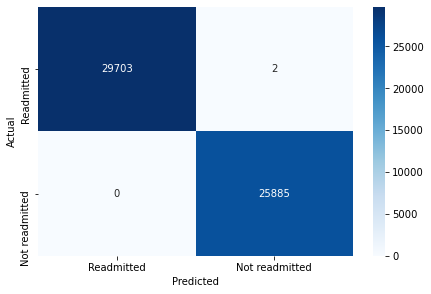

In [91]:
# confusion matrix for training data
plot_confusion_matrix(y_train_pred_prelim, y_train, dom='Train')

In [148]:
print('\n')

However, with the test set, we see that the preliminary model is not performing well in its predictions. 

All these imply an overfitting model.

In [149]:
print('\n')

Test Confusion Matrix


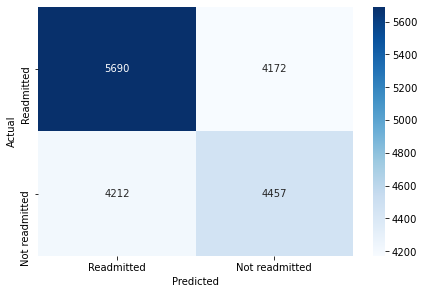

In [92]:
# confusion matrix for test data
plot_confusion_matrix(y_test_pred_prelim, y_test, dom='Test')

In [150]:
print('\n')

Now, let's look at the evaluation parameters.

**Accuracy score**

Accuracy is the most intuitive measure of performance as it is simply the ratio of correct predictions to all observations ~ TP+TN/TP+TN+FP+FN.

From the Confusion Matrix above, it is unsurprising that the preliminary model scored very highly for the training data, at **99%**, while it scored poorly for the test data, **54%**.

In [155]:
print('\n')

In [93]:
# calculate accuracy scores
print(f"Training Accuracy: {accuracy_score(y_train, y_train_pred_prelim)}")
print(f"Testing Accuracy: {accuracy_score(y_test, y_test_pred_prelim)}")

Training Accuracy: 0.9999640223061702
Testing Accuracy: 0.5475689385354271


In [151]:
print('\n')

**Precision score**

Precision is the ratio of correct positives to all predicted positives ~ TP/TP+FP.

For this exercise, it means the measure of patients that the model correctly identifies as being readmitted out of all patients who were predicted as being readmitted. In other words, when the model predicts that a patient will be readmitted, it is correct about x% of the time. In our case, 58% based on the test set.

Similarly, our preliminary model scored well for the training data, but poorly for the test data.

In [154]:
print('\n')

In [94]:
print(f"Training Precision: {precision_score(y_train, y_train_pred_prelim, pos_label='NO')}")
print(f"Testing Precision: {precision_score(y_test, y_test_pred_prelim, pos_label='NO')}")

Training Precision: 0.9999326712674634
Testing Precision: 0.5769620766578787


In [152]:
print('\n')

**Recall score**

Recall is the ratio of correct positives to all actual positives ~ TP/TP+FN. 

It gauges how accurate the model is in identifying relevant data. In our context, it means the measure of patients who were actually readmitted in which the model also correctly identifies as being readmitted. 

Our recall scores are similar to the precision scores.

In [153]:
print('\n')

In [95]:
print(f"Training Recall: {recall_score(y_train, y_train_pred_prelim, pos_label='NO')}")
print(f"Testing Recall: {recall_score(y_test, y_test_pred_prelim, pos_label='NO')}")

Training Recall: 1.0
Testing Recall: 0.574631387598465


---

<a id='feature_selection'></a>
## Feature selection

Let's look at how important the features were in the preliminary model. Removing less important features may help achieve a better performing model, as well as reducing model overfit, and reducing training time.

After calculating the feature importance scores, we see that most of the features related to changes in dosage of the individual medications are not strong contributors to readmission, except for insulin and metformin.

The bar chart below shows us that the top 10 features in descending order are:

- Number of total tests (lab and non-lab)
- Number of medications
- Time in hospital
- Primary diagnosis
- Age
- Number of total inpatient, outpatient, and emergency visits
- Number of diagnoses
- Change in insulin dosage
- Gender
- Race

As such, I will retain these top 10 features, while dropping the remaining ones from my dataset for my next model iterations. 

In [96]:
# get lists of feature importances and feature names
scores = clf_prelim.feature_importances_.tolist()
combined = list(zip(features, scores))

# sort feature scores from smallest to biggest
combined = sorted(combined, key=lambda x:x[1])

# get feature scores and names accordingly for the bar chart
feature_importance = []
feature_names = []

for i in combined:
    feature_importance.append(i[1])
    
for j in combined:
    feature_names.append(j[0])

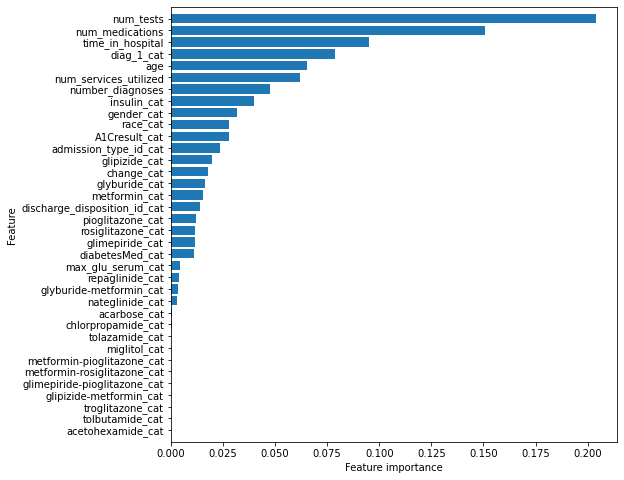

In [97]:
# define function to plot horizontal bar charts
def plot_feature_importances(model):
    plt.figure(figsize=(8,8))
    n_features = len(features)
    plt.barh(range(n_features), feature_importance, align='center')
    plt.yticks(np.arange(n_features), feature_names)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)

# visualise feature importance scores
plot_feature_importances(clf_prelim)

In [98]:
# features to retain 'feature_names'
features_retain = feature_names[-10:] # retain top 10
# features_retain = feature_names[-3:] # retain top 5

X_train = X_train[features_retain]
X_test = X_test[features_retain]

In [99]:
features_retain

['race_cat',
 'gender_cat',
 'insulin_cat',
 'number_diagnoses',
 'num_services_utilized',
 'age',
 'diag_1_cat',
 'time_in_hospital',
 'num_medications',
 'num_tests']

In [100]:
# run decision tree
dtree_prelim = tree.DecisionTreeClassifier(random_state=0) # instantiate classifier
clf_prelim = dtree_prelim.fit(X_train, y_train)
y_train_pred_prelim = clf_prelim.predict(X_train)
y_test_pred_prelim = clf_prelim.predict(X_test)

# calculate accuracy scores
print(f"Training Accuracy: {accuracy_score(y_train, y_train_pred_prelim)}")
print(f"Testing Accuracy: {accuracy_score(y_test, y_test_pred_prelim)}")

Training Accuracy: 0.9994603345925526
Testing Accuracy: 0.5427122119691328


---

<a id='pre_prune'></a>
## Pre-pruning

Decision Trees are great, but they easily overfit. To help with this, we can limit or stop the growth of the tree by changing the classifier's parameters such as its criterion, depth, minimum sample before a leaf is allowed to exist, and more. Changing these parameters is known as [pre-pruning](https://www.kaggle.com/arunmohan003/pruning-decision-trees-tutorial).

Because there are so many combinations from each set of parameter values, we use [grid search](https://www.dezyre.com/recipes/optimize-hyper-parameters-of-decisiontree-model-using-grid-search-in-python) to carry out the parameter cross-validation for us. Grid search chooses the optimum value for each parameter for us - values that in combination, give the best performance for the tree. 

I will be using **criterion**, **splitter**, **max_depth**, **min_samples_split**, and **min_samples_leaf**.

In [101]:
# set parameters
params = {'criterion': ['gini'],
          'splitter': ['best', 'random'],
          'max_depth': np.arange(2,20),
          'min_samples_split': np.arange(2,10),
          'min_samples_leaf': np.arange(2,10)}

# use grid search to find optimum values
dtree_preprune = tree.DecisionTreeClassifier()
gcv = GridSearchCV(estimator=dtree_preprune, param_grid=params)
gcv.fit(X_train, y_train)

# use optimal values to re-train pre-pruned tree
clf_preprune = gcv.best_estimator_
clf_preprune.fit(X_train, y_train)
y_train_pred_preprune = clf_preprune.predict(X_train)
y_test_pred_preprune = clf_preprune.predict(X_test)

In [157]:
print('\n')

Which gets us the following optimal values: 

In [156]:
print('\n')

In [102]:
# print best parameters
print(f"Best criterion: {clf_preprune.get_params()['criterion']}")
print(f"Best splitter: {clf_preprune.get_params()['splitter']}")
print(f"Best max_depth: {clf_preprune.get_params()['max_depth']}")
print(f"Best min_samples_split: {clf_preprune.get_params()['min_samples_split']}")
print(f"Best min_samples_leaf: {clf_preprune.get_params()['min_samples_leaf']}")

Best criterion: gini
Best splitter: best
Best max_depth: 4
Best min_samples_split: 2
Best min_samples_leaf: 2


In [158]:
print('\n')

Using these values to fit my model with gets us a pre-pruned model with following performance:

In [159]:
print('\n')

In [103]:
print(f"Training Accuracy: {accuracy_score(y_train, y_train_pred_preprune)}")
print(f"Testing Accuracy: {accuracy_score(y_test, y_test_pred_preprune)}")
print('\n')
print(f"Training Precision: {precision_score(y_train, y_train_pred_preprune, pos_label='NO')}")
print(f"Testing Precision: {precision_score(y_test, y_test_pred_preprune, pos_label='NO')}")
print('\n')
print(f"Training Recall: {recall_score(y_train, y_train_pred_preprune, pos_label='NO')}")
print(f"Testing Recall: {recall_score(y_test, y_test_pred_preprune, pos_label='NO')}")

Training Accuracy: 0.6191221442705522
Testing Accuracy: 0.614915546921375


Training Precision: 0.6316033078252283
Testing Precision: 0.6277480140402734


Training Recall: 0.6891223108776892
Testing Recall: 0.6863259947485356


In [160]:
print('\n')

Comparing the performance of my preliminary model with the pre-pruned model, we see a tradeoff between scores on the training data and the test data. The difference in scores between the training and test sets is now lower. 

Below is how the new tree looks like.

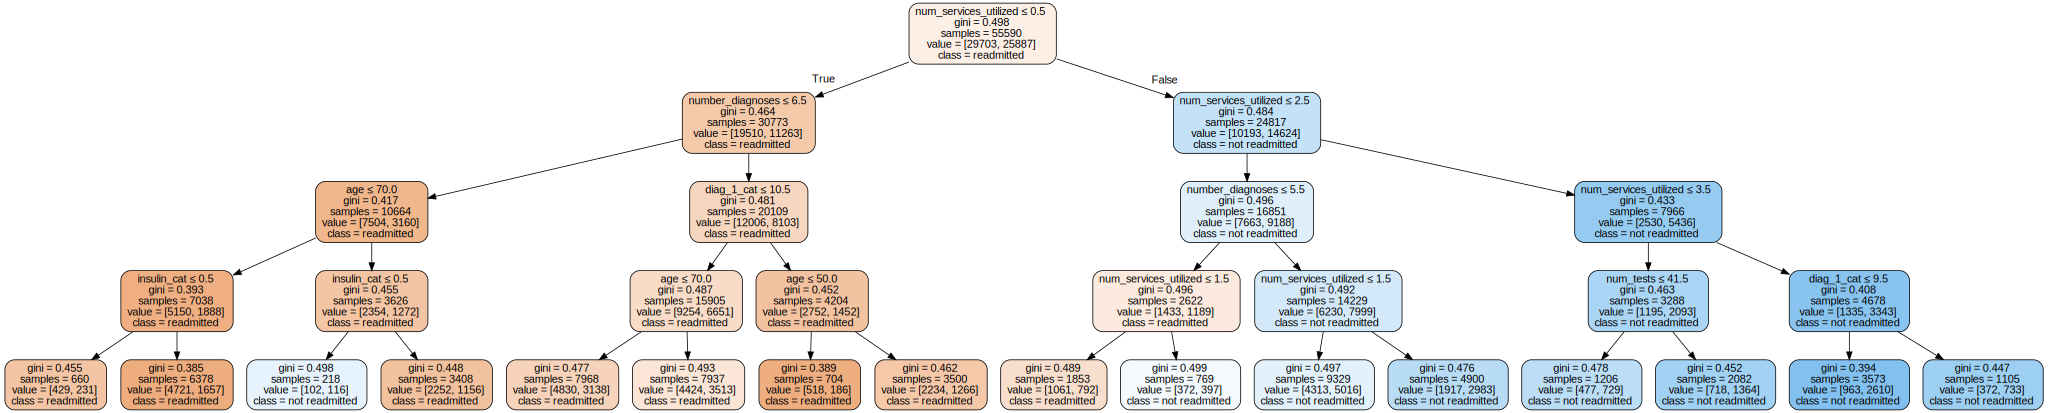

In [104]:
dot_data = tree.export_graphviz(clf_preprune, out_file=None, 
                                feature_names=X_train.columns.tolist(),  
                                class_names=['readmitted','not readmitted'],  
                                filled=True, rounded=True,  
                                special_characters=True)  

graph = graphviz.Source(dot_data)  
graph

---

<a id='post_prune'></a>
## Post-pruning

Setting different parameter constraints such as what the pre-pruning technique did is one way to avoid overfitting. However, another way to avoid overfitting is by using [cost complexity pruning, or also known as the weaklest link pruning](https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html). The gist of this technique is that it is used to control the size of the tree by finding the right parameter for alpha (which is the cost complexity parameter). Alpha is then used to calculate the [tree score](https://www.youtube.com/watch?v=D0efHEJsfHo) for each pruned tree by taking into account the sum of squared residuals (SSR) and the number of leaves of each tree (which corresponds to each alpha):

> **tree score = SSR + (alpha * total number of leaves)**

Different alphas and their corresponding trees (with different SSRs and number of leaves) give various tree scores, in which case the tree with the lowest tree score is chosen.

In [161]:
print('\n')

**Implement cost complexity pruning**

`cost_complexity_pruning_path` returns a sequence of effective alphas that is later used to determine the most appropriate alpha (ccp_alpha).

In the plot below, we see that the higher the alpha, the higher the impurity of leaves, implying a more pruned tree (a tree with a lower number of nodes). 

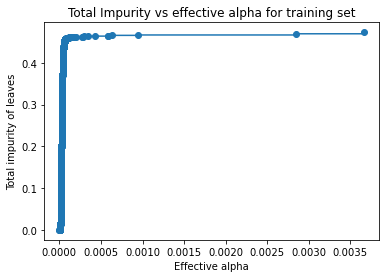

In [105]:
# calculate alphas
clf = tree.DecisionTreeClassifier()
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

# plot relationship between alphas and impurity of leaves
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("Effective alpha")
ax.set_ylabel("Total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set");

In [162]:
print('\n')

Next, we create multiple pruned trees using all effective alphas produced before, so that we can eventually pick an alpha that [maximises testing accuracy](https://medium.com/swlh/post-pruning-decision-trees-using-python-b5d4bcda8e23) without compromising much of the training accuracy.

In [106]:
# train models for each alpha
clfs = []

for i in tqdm(ccp_alphas):
    clf_postprune_alpha = tree.DecisionTreeClassifier(ccp_alpha=i)
    clf_postprune_alpha.fit(X_train, y_train)
    clfs.append(clf_postprune_alpha)

100%|██████████| 7219/7219 [1:11:03<00:00,  1.69it/s]


In [163]:
print('\n')

We plot how the different alphas influence the number of nodes and depths of the corresponding pruned trees.

100%|██████████| 7218/7218 [00:00<00:00, 1495996.75it/s]


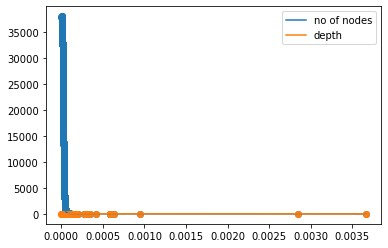

In [107]:
# remove last alpha 
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

# store node counts and depths
node_counts = []
depth = []

# get node counts and depths of each model/ alpha
for clf in tqdm(clfs):
    node_counts.append(clf.tree_.node_count)
    depth.append(clf.tree_.max_depth)

plt.scatter(ccp_alphas, node_counts)
plt.scatter(ccp_alphas, depth)
plt.plot(ccp_alphas, node_counts, label='no of nodes', drawstyle="steps-post")
plt.plot(ccp_alphas, depth, label='depth', drawstyle="steps-post")
plt.legend()

In [164]:
print('\n')

Let's visualise the training and testing accuracy scores for each pruned tree along with the tree's alpha.

Seems like the best alpha to use that gets us the maximal accuracy score for the test set is `0.00015`, although the accuracy score of the training set is also severely compromised, from the preliminary model.

That said, this alpha gives us accuracy scores (**62%** and **62%**) that are still very similar to the pre-pruned tree (**62%** and **61%**).

In addition, the post-pruned tree has a depth of 5, as opposed to the pre-pruned tree of having a depth of 4. 

100%|██████████| 7218/7218 [14:54<00:00,  8.07it/s]


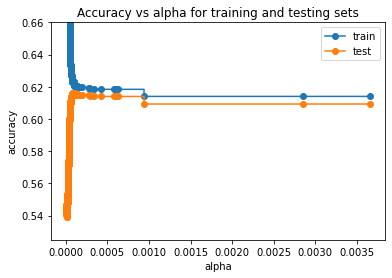

In [108]:
# store scores for plotting
train_scores = []
test_scores = []

# for each clf (corresponding to each alpha), get the accuracy score for the training and test data
for clf in tqdm(clfs):
    train_scores.append(clf.score(X_train, y_train))
    test_scores.append(clf.score(X_test, y_test))

# plot
fig, ax = plt.subplots()
ax.set_xlabel('alpha')
ax.set_ylim(0.525, 0.66)
ax.set_ylabel('accuracy')
ax.set_title('Accuracy vs alpha for training and testing sets')
ax.plot(ccp_alphas, train_scores, marker='o', label='train', drawstyle='steps-post')
ax.plot(ccp_alphas, test_scores, marker='o', label='test', drawstyle='steps-post')
ax.legend()

In [165]:
print('\n')

The alpha value of 0.00015 gets us a post-pruned model with the following performance:

In [166]:
print('\n')

In [109]:
# select optimum alpha for the post-pruned tree
dtree_postprune_final = tree.DecisionTreeClassifier(ccp_alpha=0.00015)
clf_postprune_final = dtree_postprune_final.fit(X_train, y_train)
y_train_pred_postprune3 = clf_postprune_final.predict(X_train)
y_test_pred_postprune3 = clf_postprune_final.predict(X_test)

In [111]:
print(f"Training Accuracy: {accuracy_score(y_train, y_train_pred_postprune3)}")
print(f"Testing Accuracy: {accuracy_score(y_test, y_test_pred_postprune3)}")
print('\n')
print(f"Training Precision: {precision_score(y_train, y_train_pred_postprune3, pos_label='NO')}")
print(f"Testing Precision: {precision_score(y_test, y_test_pred_postprune3, pos_label='NO')}")
print('\n')
print(f"Training Recall: {recall_score(y_train, y_train_pred_postprune3, pos_label='NO')}")
print(f"Testing Recall: {recall_score(y_test, y_test_pred_postprune3, pos_label='NO')}")

Training Accuracy: 0.6200755531570427
Testing Accuracy: 0.6156710377205763


Training Precision: 0.6231455708915608
Testing Precision: 0.619724375538329


Training Recall: 0.7311046022287311
Testing Recall: 0.7266208846697637


In [167]:
print('\n')

The post-pruned tree looks like the below:

In [168]:
print('\n')

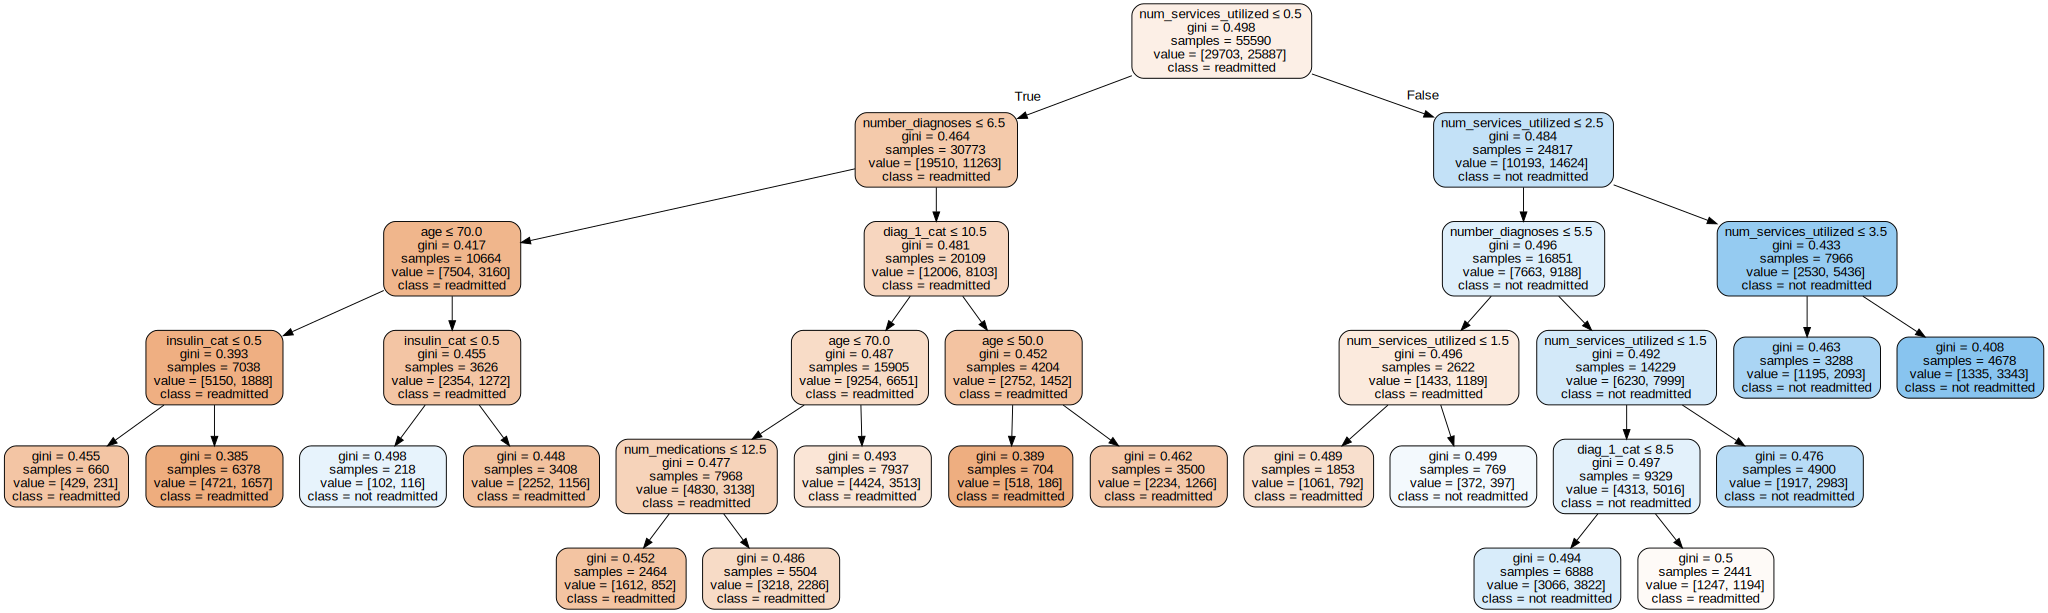

In [112]:
# plot tree
dot_data2 = tree.export_graphviz(dtree_postprune_final, out_file=None, 
                                feature_names=X_train.columns.tolist(),  
                                class_names=['readmitted','not readmitted'],  
                                filled=True, rounded=True,  
                                special_characters=True)  

graph2 = graphviz.Source(dot_data2)  
graph2

---

<a id='takeaways'></a>
## Takeaways

This exercise leveraged demographic and clinical data of diabetes patients in the US in an attempt to build a predictive model to identify patients who would be redmitted to the hospital (versus patients who won't) based on certain features. 

Seems like the key factors that contribute most to the prediction are the number of total tests done, number of medications, time spent in hospital during previous admission, type of primary diagnosis, and the age of a patient. Other factors that were less important (but still in the top 10) are the number of visits a patient paid to the hospital (whether for inpatient, outpatient, or emergency purposes), number of diagnoses, and change in insulin dosage. 

Comparing the accuracy, precision, and recall scores of my preliminary, pre-pruned, and post-pruned trees (see table for comparison below), we see that both pre-pruning and post-pruning techniques were able to resolve the issue of model overfitting. Nevertheless, the pruned trees remain sub-optimal in their performance, where both pre-pruned and post-pruned trees only scored in the 60% range for accuracy, precision, and recall. 

The pruned trees, however, scored relatively higher in recall than in precision, which implies that my models fare better in predicting readmission for patients who would ACTUALLY require readmission, and thereby reducing the risk of missing out on providing resources to treat patients who need it (aka quantity).

In comparison, the models fare poorer in their quality of prediction - there is a higher chance that a patient who gets predicted as needing readmission ACTUALLY does not need readmission, and thereby increasing the risk of resource 'wastage'. 


In [170]:
print('\n')

In [122]:
accuracy_prelim_train = int(accuracy_score(y_train, y_train_pred_prelim)*100)
accuracy_prelim_test = int(accuracy_score(y_test, y_test_pred_prelim)*100)

accuracy_preprune_train = int(accuracy_score(y_train, y_train_pred_preprune)*100)
accuracy_preprune_test = int(accuracy_score(y_test, y_test_pred_preprune)*100)

accuracy_postprune_train = int(accuracy_score(y_train, y_train_pred_postprune3)*100)
accuracy_postprune_test = int(accuracy_score(y_test, y_test_pred_postprune3)*100)

precision_prelim_train = int(precision_score(y_train, y_train_pred_prelim, pos_label='NO')*100)
precision_prelim_test = int(precision_score(y_test, y_test_pred_prelim, pos_label='NO')*100)

precision_preprune_train = int(precision_score(y_train, y_train_pred_preprune, pos_label='NO')*100)
precision_preprune_test = int(precision_score(y_test, y_test_pred_preprune, pos_label='NO')*100)

precision_postprune_train = int(precision_score(y_train, y_train_pred_postprune3, pos_label='NO')*100)
precision_postprune_test = int(precision_score(y_test, y_test_pred_postprune3, pos_label='NO')*100)

recall_prelim_train = int(recall_score(y_train, y_train_pred_prelim, pos_label='NO')*100)
recall_prelim_test = int(recall_score(y_test, y_test_pred_prelim, pos_label='NO')*100)

recall_preprune_train = int(recall_score(y_train, y_train_pred_preprune, pos_label='NO')*100)
recall_preprune_test = int(recall_score(y_test, y_test_pred_preprune, pos_label='NO')*100)

recall_postprune_train = int(recall_score(y_train, y_train_pred_postprune3, pos_label='NO')*100)
recall_postprune_test = int(recall_score(y_test, y_test_pred_postprune3, pos_label='NO')*100)


In [169]:
train_scores_df = pd.DataFrame(index=['Preliminary','Prepruned','Postpruned'],
                               columns=['Accuracy','Precision','Recall'])

train_scores_df.loc['Preliminary','Accuracy'] = accuracy_prelim_train
train_scores_df.loc['Prepruned','Accuracy'] = accuracy_preprune_train
train_scores_df.loc['Postpruned','Accuracy'] = accuracy_postprune_train
train_scores_df.loc['Preliminary','Precision'] = precision_prelim_train
train_scores_df.loc['Prepruned','Precision'] = precision_preprune_train
train_scores_df.loc['Postpruned','Precision'] = precision_postprune_train
train_scores_df.loc['Preliminary','Recall'] = recall_prelim_train
train_scores_df.loc['Prepruned','Recall'] = recall_preprune_train
train_scores_df.loc['Postpruned','Recall'] = recall_postprune_train

print(f"Evaluation scores for training set: ")
print('\n')
train_scores_df

Evaluation scores for training set: 




,Accuracy,Precision,Recall
Preliminary,99,99,100
Prepruned,61,63,68
Postpruned,62,62,73


In [142]:
print('\n')

In [171]:
test_scores_df = pd.DataFrame(index=['Preliminary','Prepruned','Postpruned'],
                               columns=['Accuracy','Precision','Recall'])

test_scores_df.loc['Preliminary','Accuracy'] = accuracy_prelim_test
test_scores_df.loc['Prepruned','Accuracy'] = accuracy_preprune_test
test_scores_df.loc['Postpruned','Accuracy'] = accuracy_postprune_test
test_scores_df.loc['Preliminary','Precision'] = precision_prelim_test
test_scores_df.loc['Prepruned','Precision'] = precision_preprune_test
test_scores_df.loc['Postpruned','Precision'] = precision_postprune_test
test_scores_df.loc['Preliminary','Recall'] = recall_prelim_test
test_scores_df.loc['Prepruned','Recall'] = recall_preprune_test
test_scores_df.loc['Postpruned','Recall'] = recall_postprune_test

print(f"Evaluation scores for test set: ")
print('\n')
test_scores_df

Evaluation scores for test set: 




,Accuracy,Precision,Recall
Preliminary,54,57,57
Prepruned,61,62,68
Postpruned,61,61,72


In [143]:
print('\n')

With all said and done, there are a few things that I wish to look at when revisiting this exercise in the future. These are:

- How different ways of categorical feature encoding affect the model performance.
- Add more features to the model.
- Study other classification evaluation parameters such as the F1 score and ROC Curve.
- Feature scaling and PCA to reduce dataset's dimensionality? Although I read some where that feature scaling is not necessary for classification models. 

Til then!

In [175]:
# to remove code cells from being seen in html: https://stackoverflow.com/questions/31517194/how-to-hide-one-specific-cell-input-or-output-in-ipython-notebook

from traitlets.config import Config
import nbformat as nbf
from nbconvert.exporters import HTMLExporter
from nbconvert.preprocessors import TagRemovePreprocessor

# Setup config
c = Config()

# Configure tag removal - be sure to tag your cells to remove  using the
# words remove_cell to remove cells. You can also modify the code to use
# a different tag word
c.TagRemovePreprocessor.remove_cell_tags = ("remove_cell",)
c.TagRemovePreprocessor.remove_all_outputs_tags = ('remove_output',)
c.TagRemovePreprocessor.remove_input_tags = ('remove_input',)
c.TagRemovePreprocessor.enabled = True

# Configure and run out exporter
c.HTMLExporter.preprocessors = ["nbconvert.preprocessors.TagRemovePreprocessor"]

exporter = HTMLExporter(config=c)
exporter.register_preprocessor(TagRemovePreprocessor(config=c),True)

# Configure and run our exporter - returns a tuple - first element with html,
# second with notebook metadata
output = HTMLExporter(config=c).from_filename("Predicting readmission rates for diabetic patients.ipynb")

# Write to output html file
with open("entry13.html",  "w") as f:
    f.write(output[0])
    